## Modelisation with UNET Pretrained with VGG16 ImageNet

In [1]:
import sys  
sys.path.insert(0, './scripts')

# Import librairies, configs, helper functions
from helpers import *

config = base_config_resized

# config["use_saved_model_path"] = "./model_v4_full_cat_8.h5"
config["val_sample_nb"] = 100
config["width"] = 224
config["height"] = 224
config["train_sample_nb"] = 400
config["epoch"] = 4

n = NotebookProcessor(config)

{
    "width": 224,
    "height": 224,
    "classes": 8,
    "epoch": 4,
    "batch_size": 3,
    "learning_rate": 0.001,
    "train_sample_nb": 400,
    "val_sample_nb": 100,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip

- Sampling the training dataset from 2975 to 400.

- Sampling the validation dataset from 500 to 100.


2024-02-27 15:41:04.995069: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-27 15:41:04.995093: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-27 15:41:04.995097: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-27 15:41:04.995136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-27 15:41:04.995164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Model definition

224x224 [UNET is lorem ipsum](https://arxiv.org/pdf/1409.1556.pdf)

## Model creation

In [2]:
def conv_block(input_tensor, num_filters, dropout_rate=0.1):  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    x = Dropout(dropout_rate)(x)  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    return x  
  
def create_model(n_classes, img_width, img_height, img_channels):    
    # Load VGG16 as the encoder with pretrained ImageNet weights  
    base_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, img_channels))  
      
    # Freeze the layers of VGG16  
    for layer in base_vgg16.layers:  
        layer.trainable = False  
      
    # Encoder - take the outputs of the VGG16 layers to create the contracting path  
    s1 = base_vgg16.get_layer("block1_conv2").output  # 64 filters  
    s2 = base_vgg16.get_layer("block2_conv2").output  # 128 filters  
    s3 = base_vgg16.get_layer("block3_conv3").output  # 256 filters  
    s4 = base_vgg16.get_layer("block4_conv3").output  # 512 filters  
    c5 = base_vgg16.get_layer("block5_conv3").output  # 512 filters, this acts as the bridge  
  
    # Start from bottom and go up, using U-Net's expansive path  
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)    
    u6 = concatenate([u6, s4])    
    c6 = conv_block(u6, 512)   
      
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)    
    u7 = concatenate([u7, s3])    
    c7 = conv_block(u7, 256)    
      
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)    
    u8 = concatenate([u8, s2])    
    c8 = conv_block(u8, 128)    
      
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)    
    u9 = concatenate([u9, s1])    
    c9 = conv_block(u9, 64)    
  
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)    
      
    model = Model(inputs=[base_vgg16.input], outputs=[outputs])  
      
    return model  

## Model Stats

In [3]:
model = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n.set_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [4]:
n.model_fit()


Train steps: 133
Balidation steps: 33

---------------------


Epoch 1/4


2024-02-27 15:41:06.217791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


133/133 [==============================] - 40s 296ms/step - loss: 0.7345 - accuracy: 0.7756 - val_loss: 1.7099 - val_accuracy: 0.5597
Epoch 2/4
133/133 [==============================] - 43s 322ms/step - loss: 0.5236 - accuracy: 0.8411 - val_loss: 0.8812 - val_accuracy: 0.7815
Epoch 3/4
133/133 [==============================] - 42s 318ms/step - loss: 0.4848 - accuracy: 0.8511 - val_loss: 1.1136 - val_accuracy: 0.6664
Epoch 4/4
133/133 [==============================] - 50s 379ms/step - loss: 0.4632 - accuracy: 0.8578 - val_loss: 0.6235 - val_accuracy: 0.8179

Model trained!



In [5]:
n.model_save("model_delete.h5")

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P8/output/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


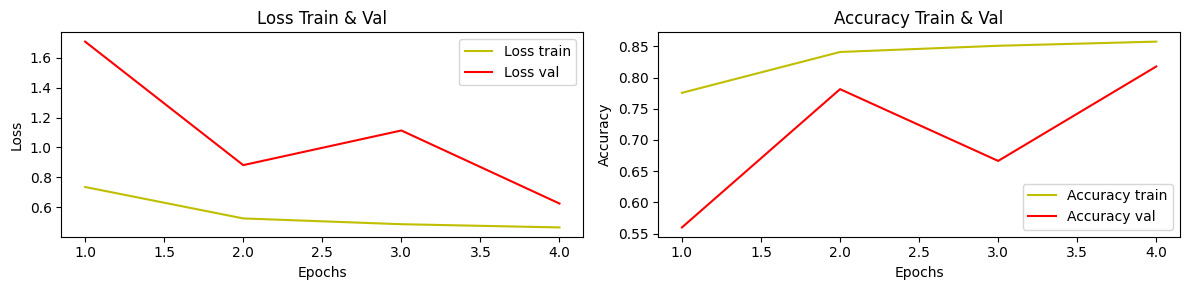

In [6]:
display_loss_and_accuracy(n.model_fit_history)

1/1 [==============================] - 0s 281ms/step
Instructions for updating:
Use tf.identity with explicit device placement instead.


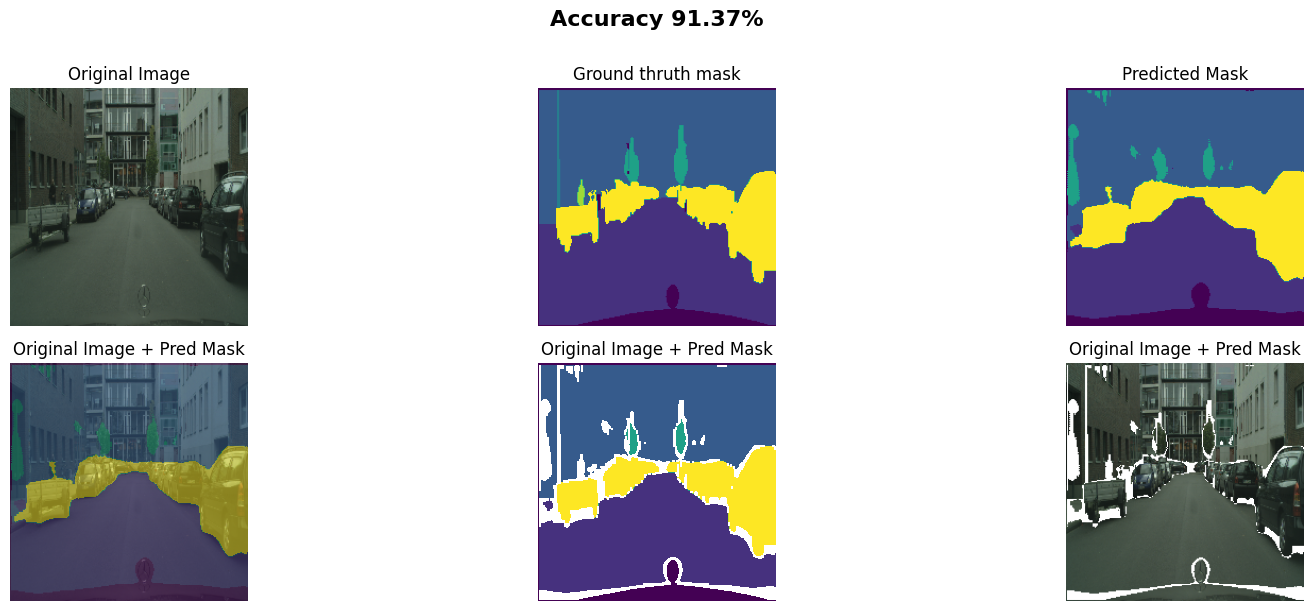

In [7]:
n.model_predict_with_display_and_accuracy(n.img["val"][3],n.mask["val"][3])

## Model Inference

1/1 [==============================] - 0s 16ms/step
AA (224, 224, 3)
BB (224, 224, 3)


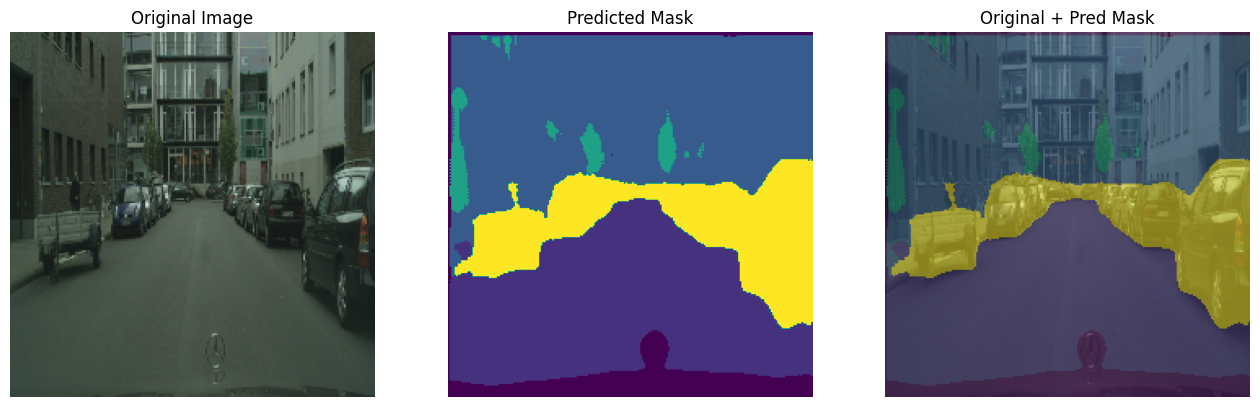

In [8]:
n.model_predict_with_display(n.img["val"][3])